In [1]:
import pandas as pd
sent=pd.read_pickle(r'C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\Sentiment Additions\subs_lr_sent.pickle')

In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [2]:
from tqdm import tqdm
import datetime
tqdm.pandas()
#connect local PATH
p = os.path.abspath(r'C:\Users\Ben\Desktop\Diplomatiki')
sys.path.append(str(p))
from CryptoSent.tools.crypto_coin_actual import get_btc_actual_hourly
from CryptoSent.tools import evaluation as eval
btc=get_btc_actual_hourly()


100%|██████████| 30907/30907 [00:00<00:00, 160272.09it/s]


In [3]:
def result_processing(sentiment,coin_price,resample_period='d'):
    sdmin=datetime.datetime.strftime(sentiment.index.min(),'%Y-%m-%d')
    sdmax=datetime.datetime.strftime(sentiment.index.max(),'%Y-%m-%d')
    sent=sentiment.resample(resample_period).sum()
    btc=coin_price[sdmin:sdmax].resample(resample_period).mean()
    merres=pd.concat([sent,btc],axis=1)
    merres.loc[:,'avg_hl_diff']=merres.avg_hl.diff()
    merres.loc[:,'avg_hl_pct_change']=merres.avg_hl.pct_change()
    merres.loc[:,'sent_db_shift']=sent.shift(1)
    merres.loc[:,'sent_db_ptc_change']=sent.pct_change()
    return merres

In [57]:
merres=result_processing(sent.polarity_lr,btc.avg_hl,resample_period='d')

In [58]:
merres=merres[['polarity_lr','avg_hl']]

In [59]:
ft_pred=10
validate_merres=merres.tail(ft_pred)
merres.drop(merres.tail(ft_pred).index,inplace=True)

In [60]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [61]:
# between 0-1 scaller
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(merres)
dataY = y_scaler.fit_transform(merres[['avg_hl']])

In [62]:
hist_window = 60
horizon = 6
TRAIN_SPLIT = 600
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi = custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [63]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[8.72407884e-02 5.48641929e-03]
 [1.40392218e-01 7.55319253e-03]
 [1.43074513e-01 7.76895921e-03]
 [1.54593149e-01 6.95643049e-03]
 [1.33461569e-01 7.81196346e-03]
 [9.75045419e-02 8.23970741e-03]
 [1.49223511e-01 1.09328991e-02]
 [1.98099705e-01 1.06414728e-02]
 [1.62415284e-01 1.06897399e-02]
 [1.57824725e-01 7.37076075e-03]
 [1.38737689e-01 4.50243174e-03]
 [9.90932241e-02 4.29867811e-03]
 [1.16800317e-01 3.62952581e-03]
 [1.56366335e-01 3.46664078e-03]
 [1.37666843e-01 4.61545486e-03]
 [1.64964661e-01 3.93318008e-03]
 [1.57203186e-01 3.90747946e-03]
 [1.38251842e-01 4.14007132e-03]
 [1.10391372e-01 4.99245975e-03]
 [1.08052037e-01 4.10409461e-03]
 [1.31689657e-01 2.82351499e-03]
 [1.79200557e-01 3.05016447e-03]
 [1.43052863e-01 3.39032244e-03]
 [1.54545515e-01 3.10156572e-03]
 [1.45346363e-01 3.16393645e-03]
 [6.22927699e-02 3.42091149e-03]
 [7.50250069e-02 2.95895205e-03]
 [1.32359583e-01 1.22422407e-03]
 [1.41923540e-01 5.51282371e-04]
 [1.55095188e

In [64]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [69]:
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True), 
                               input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')

In [70]:
model_path = r'C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Papers\hands-on-time-series-analylsis-python-master\Chapter 7\Bidirectional_LSTM_Multivariate.h5'

In [71]:
EVALUATION_INTERVAL = 20
EPOCHS = 15
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, 
validation_steps=50, verbose=1,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'), 
tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])


Epoch 1/15
20/20 [==============================] - 13s 653ms/step - loss: 0.0024 - val_loss: 0.1114
Epoch 2/15
20/20 [==============================] - 12s 615ms/step - loss: 9.9783e-04 - val_loss: 0.0666
Epoch 3/15
20/20 [==============================] - 13s 637ms/step - loss: 7.1144e-04 - val_loss: 0.0413
Epoch 4/15
20/20 [==============================] - 14s 680ms/step - loss: 5.7992e-04 - val_loss: 0.0449
Epoch 5/15
20/20 [==============================] - 14s 712ms/step - loss: 4.6806e-04 - val_loss: 0.0374
Epoch 6/15
20/20 [==============================] - 17s 843ms/step - loss: 4.1663e-04 - val_loss: 0.0385
Epoch 7/15
20/20 [==============================] - 20s 982ms/step - loss: 3.5976e-04 - val_loss: 0.0375
Epoch 8/15
20/20 [==============================] - 20s 1s/step - loss: 3.1524e-04 - val_loss: 0.0366
Epoch 9/15
20/20 [==============================] - 19s 942ms/step - loss: 2.9041e-04 - val_loss: 0.0395
Epoch 10/15
20/20 [==============================] - 19s 945ms

In [72]:
Trained_model = tf.keras.models.load_model(model_path)

In [73]:
Trained_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 60, 300)           183600    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100)               140400    
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 126       
Total params: 326,146
Trainable params: 326,146
Non-trainable params: 0
_________________________________________________________________


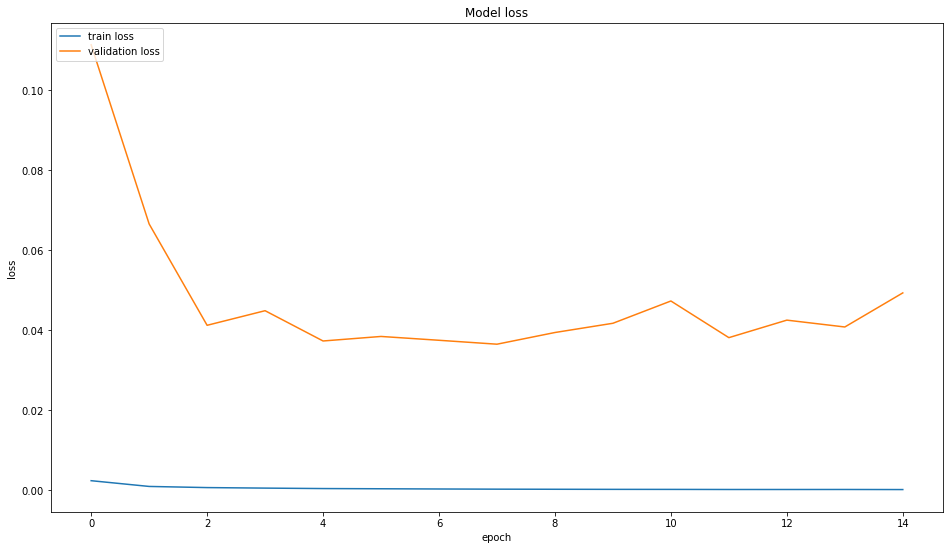

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [92]:
data_val = x_scaler.fit_transform(merres.tail(60))

val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
Predicted_results = Trained_model.predict(val_rescaled)

In [93]:
Predicted_results

array([[0.13758291, 0.11371288, 0.14142738, 0.11512397, 0.10758538,
        0.09173125]], dtype=float32)

In [94]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [95]:
Predicted_results_Inv_trans

array([[11633.918, 10199.545, 11864.937, 10284.339,  9831.338,  8878.648]],
      dtype=float32)

In [96]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [97]:
len(Predicted_results_Inv_trans[0])

6

In [98]:
len(validate_merres['avg_hl'])

10

In [99]:
timeseries_evaluation_metrics_func(validate_merres['avg_hl'],Predicted_results_Inv_trans[0])

Evaluation metric results:-


ValueError: Found input variables with inconsistent numbers of samples: [10, 6]

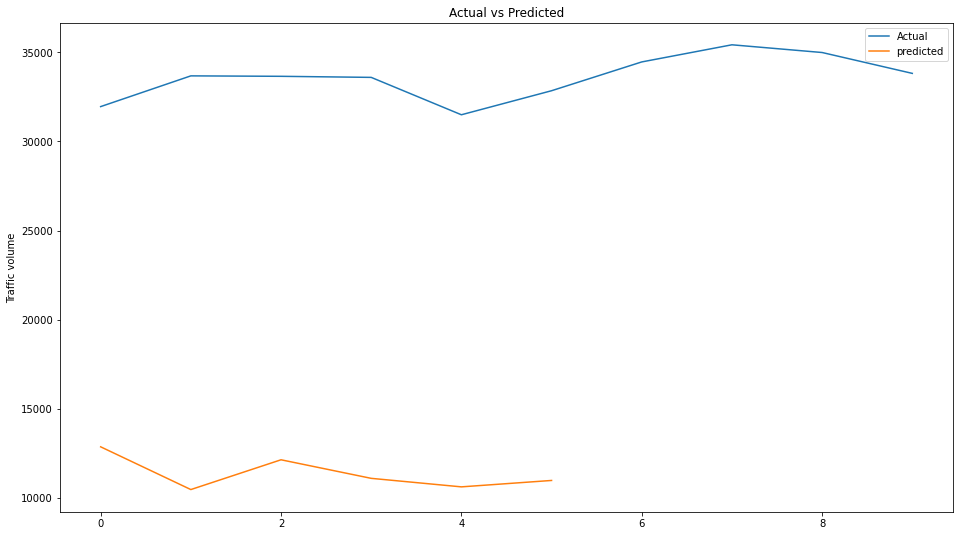

In [83]:
plt.plot( list(validate_merres['avg_hl']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()

<AxesSubplot:>

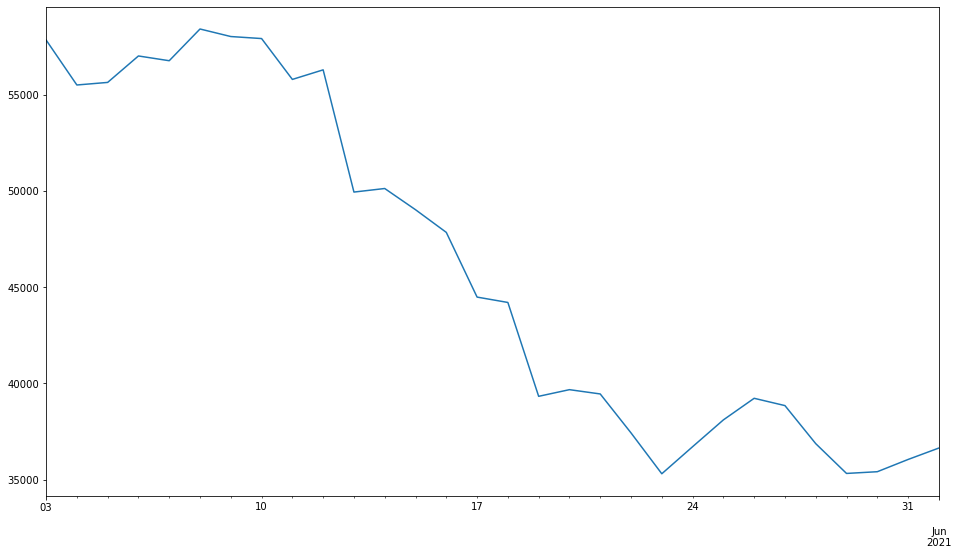

In [ ]:
merres.avg_hl.tail(10).plot()

# Example from the book


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [2]:
df = pd.read_csv(r'C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Papers\hands-on-time-series-analylsis-python-master\Data\Metro_Interstate_Traffic_Volume.csv')

In [3]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [5]:
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [6]:
holiday_le = preprocessing.LabelEncoder()

In [7]:
#labeling 
df['holiday_le'] = holiday_le.fit_transform(df['holiday']) 
weather_main_le = preprocessing.LabelEncoder()
df['weather_main_le'] = weather_main_le.fit_transform(df['weather_main']) 
weather_description_le = preprocessing.LabelEncoder()
df['weather_description_le'] = weather_description_le.fit_transform(df['weather_description']) 

In [8]:
df = df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']]

In [9]:
validate = df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']].tail(10)
df.drop(df.tail(10).index,inplace=True)

In [10]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [11]:
validate = df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']].tail(10)
df.drop(df.tail(10).index,inplace=True)

In [12]:
# between 0-1 scaller
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']])
dataY = y_scaler.fit_transform(df[['traffic_volume']])

In [13]:
hist_window = 48
horizon = 10
TRAIN_SPLIT = 30000
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi = custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [14]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.         0.92972555 0.         0.4        0.63636364 0.1
  0.7        0.76167582]
 [0.         0.93320863 0.         0.75       0.63636364 0.1
  0.06666667 0.62032967]
 [0.         0.93391815 0.         0.9        0.63636364 0.1
  0.56666667 0.65480769]
 [0.         0.93569194 0.         0.9        0.63636364 0.1
  0.56666667 0.69038462]
 [0.         0.93894927 0.         0.75       0.63636364 0.1
  0.06666667 0.67554945]
 [0.         0.94081981 0.         0.01       0.63636364 0.
  0.73333333 0.71167582]
 [0.         0.94549618 0.         0.01       0.63636364 0.
  0.73333333 0.76703297]
 [0.         0.94772148 0.         0.01       0.63636364 0.
  0.73333333 0.82623626]
 [0.         0.9486245  0.         0.2        0.63636364 0.1
  0.13333333 0.79546703]
 [0.         0.94527042 0.         0.2        0.63636364 0.1
  0.13333333 0.65521978]
 [0.         0.93840101 0.         0.2        0.63636364 0.1
  0.13333333 0.48612637]
 [0.         0.93327313 0. 

In [15]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [16]:
Bi_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150, return_sequences=True), 
                               input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=horizon),
])
Bi_lstm_model.compile(optimizer='adam', loss='mse')

In [17]:
model_path = r'C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Papers\hands-on-time-series-analylsis-python-master\Chapter 7\Bidirectional_LSTM_Multivariate.h5'

In [19]:
EVALUATION_INTERVAL = 20
EPOCHS = 15
history = Bi_lstm_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL, validation_data=val_data_multi, 
validation_steps=50, verbose=1,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'), 
tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)])


Epoch 1/15
20/20 [==============================] - 14s 697ms/step - loss: 0.0975 - val_loss: 0.0765
Epoch 2/15
20/20 [==============================] - 12s 575ms/step - loss: 0.0871 - val_loss: 0.0655
Epoch 3/15
20/20 [==============================] - 13s 653ms/step - loss: 0.0798 - val_loss: 0.0670
Epoch 4/15
20/20 [==============================] - 13s 656ms/step - loss: 0.0768 - val_loss: 0.0616
Epoch 5/15
20/20 [==============================] - 14s 703ms/step - loss: 0.0653 - val_loss: 0.0540
Epoch 6/15
20/20 [==============================] - 16s 780ms/step - loss: 0.0626 - val_loss: 0.0540
Epoch 7/15
20/20 [==============================] - 16s 815ms/step - loss: 0.0666 - val_loss: 0.0501
Epoch 8/15
20/20 [==============================] - 15s 758ms/step - loss: 0.0594 - val_loss: 0.0494
Epoch 9/15
20/20 [==============================] - 15s 733ms/step - loss: 0.0669 - val_loss: 0.0567
Epoch 10/15
20/20 [==============================] - 14s 717ms/step - loss: 0.0603 - val_lo

In [20]:
Trained_model = tf.keras.models.load_model(model_path)

In [21]:
# Show the model architecture
Trained_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 48, 300)           190800    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               140400    
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
Total params: 333,430
Trainable params: 333,430
Non-trainable params: 0
_________________________________________________________________


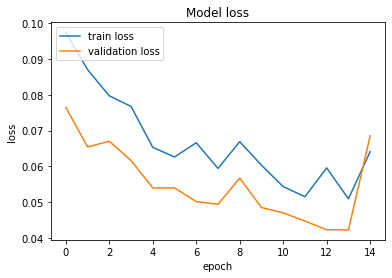

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left')
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

In [23]:
data_val = x_scaler.fit_transform(df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']].tail(48))

In [24]:
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])

In [25]:
Predicted_results = Trained_model.predict(val_rescaled)

In [26]:
Predicted_results

array([[ 0.02091687,  0.08576003, -0.05128491,  0.00420065,  0.21606444,
         0.3125168 ,  0.50988996,  0.5103624 ,  0.5837423 ,  0.6715363 ]],
      dtype=float32)

In [27]:
Predicted_results_Inv_trans = y_scaler.inverse_transform(Predicted_results)

In [28]:
Predicted_results_Inv_trans

array([[ 152.27483 ,  624.33307 , -373.35413 ,   30.580748, 1572.9491  ,
        2275.1223  , 3711.999   , 3715.4382  , 4249.644   , 4888.7847  ]],
      dtype=float32)

In [29]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [30]:
timeseries_evaluation_metrics_func(validate['traffic_volume'],Predicted_results_Inv_trans[0])

Evaluation metric results:-
MSE is : 746568.75558513
MAE is : 772.8768999099732
RMSE is : 864.0421029007382
MAPE is : 79.38567288164565
R2 is : 0.591940417317618



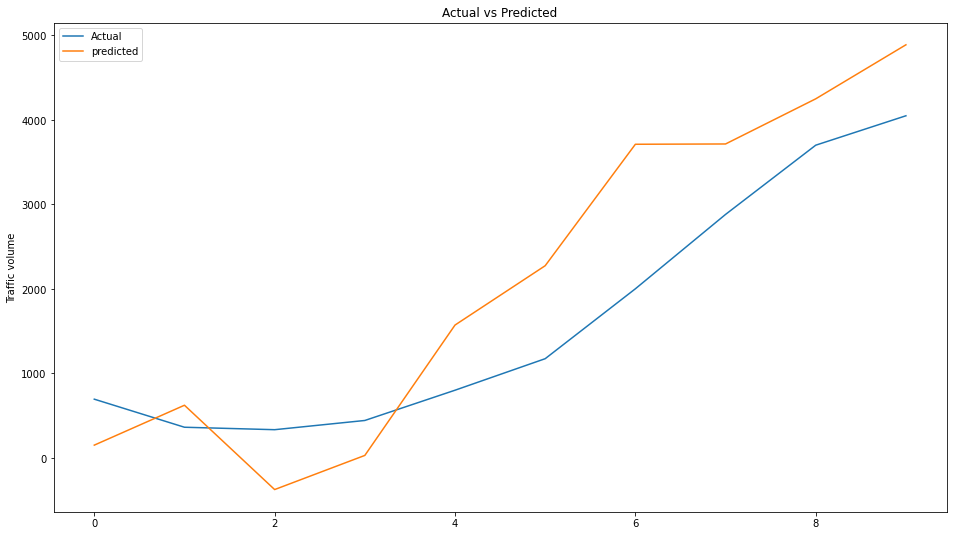

In [31]:
plt.plot( list(validate['traffic_volume']))
plt.plot( list(Predicted_results_Inv_trans[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual','predicted'))
plt.show()